In [1]:
import pandas as pd
import numpy as np
import pickle

from utils import count_parameters, plot_metrics
from transformer_scratch import Part, JetParticleDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC, F1Score

from sklearn.model_selection import train_test_split

from time import time
import gc

In [2]:
print('Preparing data...')
start = time()
        
file_path = '/home/asugu/work/part/event_data_true_1m.pkl'

with open(file_path, 'rb') as file:
    event_data = pickle.load(file)
    
df = pd.DataFrame(event_data)


Preparing data...


In [ ]:
#_______________________________________________________HYPERPARAMETERS_______________________________________________________#

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  #"mps" if torch.backends.mps.is_available() else "cpu"  

batch_size = 2048
n_epochs = 100
learning_rate = 0.001

scheduler_step = 17
scheduler_gamma = 0.5

input_size = 50   # padded length
embed_size = 64
n_heads = 8
n_part_layers = 4
n_cls_layers = 2

print(f'Selected device: {device}')

Selected device: cuda:0


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['btag'])

train_dataset = JetParticleDataset(train_df, device=device)
test_dataset = JetParticleDataset(test_df, device=device)

print(len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)    # you don't need this


39705


In [ ]:
del df, train_df, test_df
gc.collect()

finish = time()

print(f"Data preperation took {finish-start} seconds.")

Data preperation took 1.4235589504241943 seconds.


In [ ]:
print('Building model...', end='\r')

model = Part(input_dim=input_size, embed_dim=embed_size, num_heads=n_heads, num_layers=n_part_layers, num_cls_layers=n_cls_layers) 
count_parameters(model)

##################################################### Loss and Optimizer Settings #####################################################

criterion = nn.BCELoss()         
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)


+------------------------------------+------------+
|              Modules               | Parameters |
+------------------------------------+------------+
|             cls_token              |     64     |
|       embed.input_bn.weight        |     50     |
|        embed.input_bn.bias         |     50     |
|        embed.embed.0.weight        |     50     |
|         embed.embed.0.bias         |     50     |
|        embed.embed.1.weight        |    3200    |
|         embed.embed.1.bias         |     64     |
|       pair_embed.conv.weight       |    800     |
|        pair_embed.conv.bias        |     8      |
|          blocks.0.w_resid          |     64     |
|   blocks.0.pre_attn_norm.weight    |     64     |
|    blocks.0.pre_attn_norm.bias     |     64     |
|    blocks.0.attn.in_proj_weight    |   12288    |
|     blocks.0.attn.in_proj_bias     |    192     |
|   blocks.0.attn.out_proj.weight    |    4096    |
|    blocks.0.attn.out_proj.bias     |     64     |
|   blocks.0

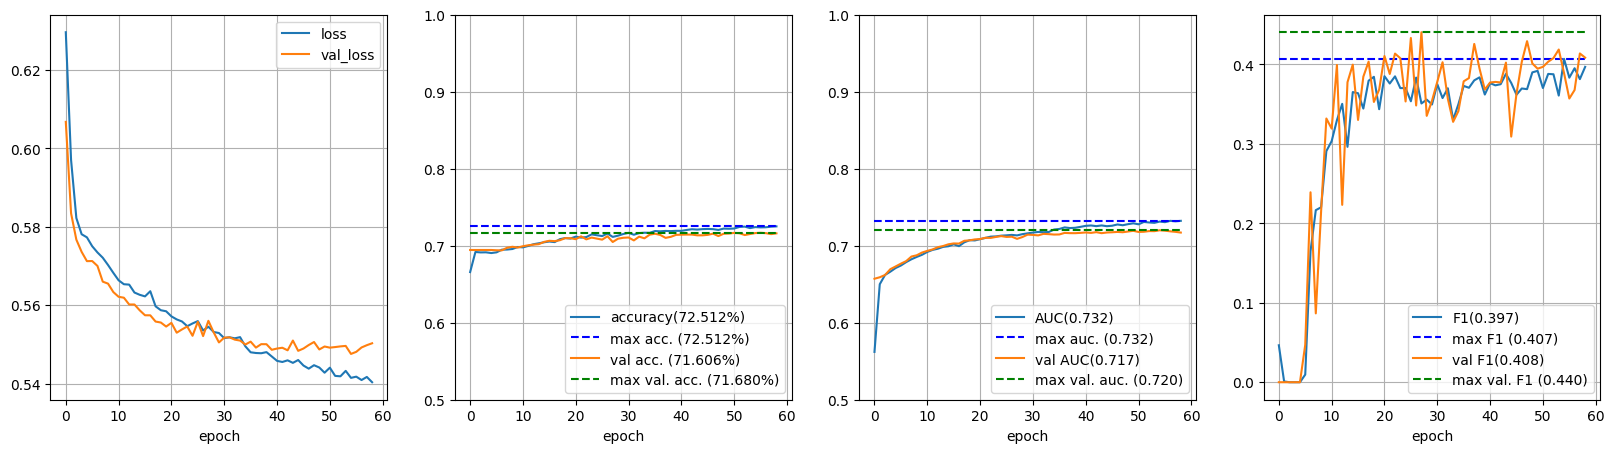

Training: Epoch [59/100] --- Loss: 0.5403 --- Accuracy: 0.7251 --- AUC: 0.732
Test    : Epoch [59/100] --- Loss: 0.5503 --- Accuracy: 0.7161 --- AUC: 0.717
Learning rate was set to 0.00013.


KeyboardInterrupt: 

In [ ]:
epoch_train_loss = []
epoch_train_accuracy = []
epoch_train_auc = []
epoch_train_f1 = []
epoch_val_loss = []
epoch_val_accuracy = []
epoch_val_auc = []
epoch_val_f1 = []

acc_metric = BinaryAccuracy().to(device)
auc_metric = AUROC(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)

model.to(device)


for i_epoch in range(n_epochs):

    train_losses = []
    train_accuracies = []
    train_aucs = []
    train_f1s =[]
    val_losses = []
    val_accuracies = []
    val_aucs = []
    val_f1s = []


    lr = optimizer.param_groups[0]['lr']
    print(f'Learning rate was set to {lr:.5f}.')

    model.train()
    for batch_jet_inputs, batch_particle_inputs, batch_four_momenta, batch_labels in train_dataloader: 

        particle_inputs = batch_particle_inputs
        jet_inputs = batch_jet_inputs
        four_momenta = batch_four_momenta
        train_label = batch_labels
     
        d0_values = particle_inputs[:, 2, :]  
        normalized_d0_values = train_dataset.normalize_d0(d0_values)

        optimizer.zero_grad()
        train_pred = model(particle_inputs,four_momenta,batch_jet_inputs,normalized_d0_values)
        loss = criterion(train_pred, train_label)


        if not torch.isnan(loss):  
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())
        train_accuracy = acc_metric(train_pred, train_label)
        train_accuracies.append(train_accuracy.item())
        train_auc = auc_metric(train_pred, train_label)
        train_aucs.append(train_auc.item())
        train_f1 = f1_metric(train_pred, train_label)
        train_f1s.append(train_f1.item())
    
    scheduler.step()

    print('Evaluating metrics...', end='\r')

    model.eval()
    with torch.no_grad():
        for val_jet_inputs, val_particle_inputs, val_four_momenta, val_labels in test_dataloader: 
            val_d0_values = val_particle_inputs[:, 2, :]  
            val_normalized_d0_values = test_dataset.normalize_d0(val_d0_values)

            val_preds = model(val_particle_inputs,val_four_momenta,val_jet_inputs,val_normalized_d0_values)
            val_loss = criterion(val_preds, val_labels)   
            val_losses.append(val_loss.item())
            val_accuracy = acc_metric(val_preds, val_labels)
            val_accuracies.append(val_accuracy.item())
            val_auc = auc_metric(val_preds, val_labels)
            val_aucs.append(val_auc.item())
            val_f1 = f1_metric(val_preds,val_labels)
            val_f1s.append(val_f1.item())
        epoch_val_loss.append(sum(val_losses) / len(val_losses))
        epoch_val_accuracy.append(sum(val_accuracies) / len(val_accuracies))
        epoch_val_auc.append(sum(val_aucs) / len(val_aucs))
        epoch_val_f1.append(sum(val_f1s) / len(val_f1s))
             
    epoch_train_loss.append( sum(train_losses) / len(train_losses))
    epoch_train_accuracy.append(sum(train_accuracies) / len(train_accuracies))
    epoch_train_auc.append(sum(train_aucs) / len(train_aucs))
    epoch_train_f1.append(sum(train_f1s) / len(train_f1s))
 
    plot_metrics(np.arange(i_epoch+1), epoch_train_loss, epoch_val_loss, epoch_train_accuracy, epoch_val_accuracy, epoch_train_auc, epoch_val_auc, epoch_train_f1, epoch_val_f1)

    print('Evaluating metrics finished!', end='\r')
    print(f'Training: Epoch [{i_epoch + 1}/{n_epochs}] --- Loss: {epoch_train_loss[-1]:.4f} --- Accuracy: {epoch_train_accuracy[-1]:.4f} --- AUC: {epoch_train_auc[-1]:.3f}\nTest    : Epoch [{i_epoch + 1}/{n_epochs}] --- Loss: {epoch_val_loss[-1]:.4f} --- Accuracy: {epoch_val_accuracy[-1]:.4f} --- AUC: {epoch_val_auc[-1]:.3f}\n', end='\r')
    
keys = ['train_losses', 'train_accuracies', 'train_aucs', 'val_losses', 'val_accuracies', 'val_aucs']
values = [train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs]
dict_metrics = {keys[i]: values[i] for i in range(len(keys))}